# exp009 低価格帯(1000万以下)エラー分析

## 分析目的
- 1000万以下の物件でMAPEが高い原因を特定
- 次回実験(exp010)での改善策を検討

## 主な発見
1. **大エラーの100%が過大予測** - モデルが低価格を予測できていない
2. **広面積×低価格が問題** - 面積が大きいほどエラーが大きい
3. **単価の違い** - 広い物件は単価6.5万円/㎡（通常15.3万円/㎡）

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from pathlib import Path

# パス設定（notebooksから見た相対パス）
notebook_dir = Path.cwd()
if "notebooks" in str(notebook_dir):
    exp_dir = notebook_dir.parent
else:
    exp_dir = Path("06_experiments/exp009_landprice")

output_dir = exp_dir / "outputs"
data_dir = exp_dir.parent.parent / "data/raw"

plt.rcParams["font.family"] = "IPAexGothic"
plt.rcParams["axes.unicode_minus"] = False

print(f"Output dir: {output_dir}")
print(f"Data dir: {data_dir}")

Output dir: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp009_landprice/outputs
Data dir: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/data/raw


## 1. データ読み込み

In [2]:
# OOF予測の読み込み
oof_df = pl.read_csv(output_dir / "oof_predictions_20251127_091113.csv")

# trainデータ
train = pl.read_csv(data_dir / "train.csv", infer_schema_length=50000)
train = train.with_columns(oof_df["actual"].alias("y"))
train = train.with_columns(oof_df["predicted"].alias("pred"))

# エラー計算
train = train.with_columns([
    (pl.col("pred") - pl.col("y")).alias("error"),
    ((pl.col("pred") - pl.col("y")).abs() / pl.col("y") * 100).alias("ape"),
])

print(f"全体: {len(train):,}件, MAPE: {train['ape'].mean():.2f}%")

全体: 363,924件, MAPE: 12.48%


## 2. 価格帯別MAPE分析

In [3]:
# 価格帯別分析
price_ranges = [
    (0, 5_000_000, "~500万"),
    (5_000_000, 10_000_000, "500-1000万"),
    (10_000_000, 20_000_000, "1000-2000万"),
    (20_000_000, 30_000_000, "2000-3000万"),
    (30_000_000, 50_000_000, "3000-5000万"),
    (50_000_000, 100_000_000, "5000万-1億"),
    (100_000_000, float("inf"), "1億以上"),
]

results = []
for low, high, label in price_ranges:
    subset = train.filter((pl.col("y") >= low) & (pl.col("y") < high))
    if len(subset) > 0:
        results.append({
            "価格帯": label,
            "件数": len(subset),
            "割合": round(len(subset) / len(train) * 100, 1),
            "MAPE": round(subset["ape"].mean(), 2),
            "中央値APE": round(subset["ape"].median(), 2),
        })

result_df = pl.DataFrame(results)
print(result_df)

shape: (7, 5)
┌─────────────┬────────┬──────┬───────┬───────────┐
│ 価格帯      ┆ 件数   ┆ 割合 ┆ MAPE  ┆ 中央値APE │
│ ---         ┆ ---    ┆ ---  ┆ ---   ┆ ---       │
│ str         ┆ i64    ┆ f64  ┆ f64   ┆ f64       │
╞═════════════╪════════╪══════╪═══════╪═══════════╡
│ ~500万      ┆ 1290   ┆ 0.4  ┆ 33.97 ┆ 21.98     │
│ 500-1000万  ┆ 47066  ┆ 12.9 ┆ 20.39 ┆ 11.65     │
│ 1000-2000万 ┆ 120157 ┆ 33.0 ┆ 12.97 ┆ 9.12      │
│ 2000-3000万 ┆ 94034  ┆ 25.8 ┆ 10.32 ┆ 7.62      │
│ 3000-5000万 ┆ 75203  ┆ 20.7 ┆ 9.58  ┆ 7.05      │
│ 5000万-1億  ┆ 22779  ┆ 6.3  ┆ 10.64 ┆ 7.75      │
│ 1億以上     ┆ 3395   ┆ 0.9  ┆ 13.87 ┆ 9.69      │
└─────────────┴────────┴──────┴───────┴───────────┘


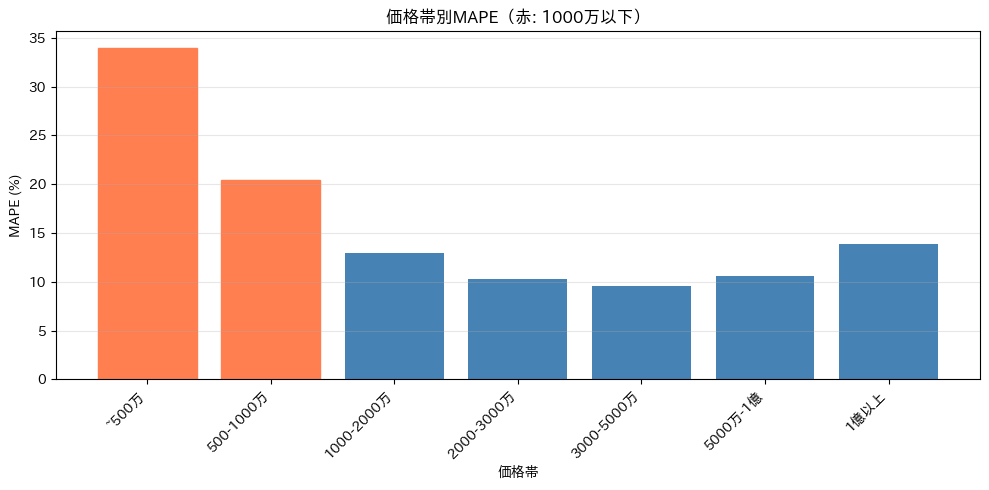

In [4]:
# 価格帯別MAPEの可視化
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(result_df))
bars = ax.bar(x, result_df["MAPE"].to_numpy(), color="steelblue")

# 1000万以下を強調
bars[0].set_color("coral")
bars[1].set_color("coral")

ax.set_xlabel("価格帯")
ax.set_ylabel("MAPE (%)")
ax.set_title("価格帯別MAPE（赤: 1000万以下）")
ax.set_xticks(x)
ax.set_xticklabels(result_df["価格帯"].to_list(), rotation=45, ha="right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "mape_by_price_range.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. 1000万以下の詳細分析

In [5]:
# 1000万以下に絞り込み
low_price = train.filter(pl.col("y") < 10_000_000)

print(f"1000万以下の物件数: {len(low_price):,} ({len(low_price)/len(train)*100:.1f}%)")
print(f"MAPE: {low_price['ape'].mean():.2f}%")
print(f"中央値APE: {low_price['ape'].median():.2f}%")

# 予測傾向
over_predict = (low_price["pred"] > low_price["y"]).sum()
under_predict = (low_price["pred"] < low_price["y"]).sum()
print()
print("予測傾向:")
print(f"  過大予測: {over_predict:,}件 ({over_predict/len(low_price)*100:.1f}%)")
print(f"  過小予測: {under_predict:,}件 ({under_predict/len(low_price)*100:.1f}%)")

1000万以下の物件数: 48,356 (13.3%)
MAPE: 20.75%
中央値APE: 11.82%

予測傾向:
  過大予測: 34,628件 (71.6%)
  過小予測: 13,728件 (28.4%)


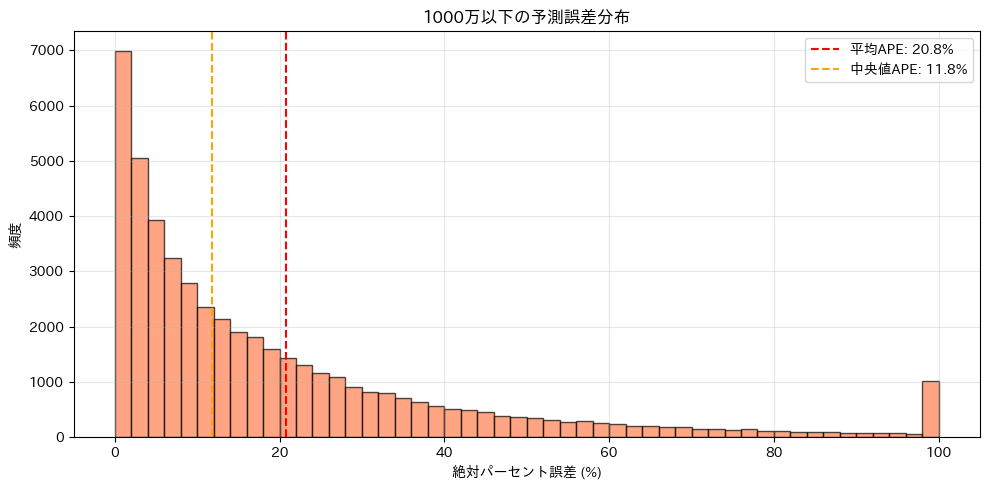

In [6]:
# APE分布
fig, ax = plt.subplots(figsize=(10, 5))

ape = low_price["ape"].to_numpy()
ape_clipped = np.clip(ape, 0, 100)

ax.hist(ape_clipped, bins=50, edgecolor="black", alpha=0.7, color="coral")
ax.axvline(ape.mean(), color="red", linestyle="--", label=f"平均APE: {ape.mean():.1f}%")
ax.axvline(np.median(ape), color="orange", linestyle="--", label=f"中央値APE: {np.median(ape):.1f}%")
ax.set_xlabel("絶対パーセント誤差 (%)")
ax.set_ylabel("頻度")
ax.set_title("1000万以下の予測誤差分布")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "ape_distribution_low_price.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. 1000万以下 vs 1000万以上の特徴量比較

In [7]:
high_price = train.filter(pl.col("y") >= 10_000_000)

print("【数値特徴量の比較】")
comparison = []
for col, name in [("house_area", "専有面積"), ("balcony_area", "バルコニー"),
                  ("walk_distance1", "徒歩距離"), ("room_kaisuu", "部屋階")]:
    if col in train.columns:
        low_mean = low_price[col].mean()
        high_mean = high_price[col].mean()
        comparison.append({"特徴量": name, "1000万以下": round(low_mean, 1), "1000万以上": round(high_mean, 1)})

print(pl.DataFrame(comparison))

# 築年数
print()
print("【築年数比較】")
for df, name in [(low_price, "1000万以下"), (high_price, "1000万以上")]:
    ref_year = df["snapshot_create_date"].str.slice(0, 4).cast(pl.Int64)
    year_built = df["year_built"] // 100
    age = (ref_year - year_built).clip(0, None)
    print(f"  {name}: 平均 {age.mean():.1f}年, 中央値 {age.median():.0f}年")

【数値特徴量の比較】
shape: (4, 3)
┌────────────┬────────────┬────────────┐
│ 特徴量     ┆ 1000万以下 ┆ 1000万以上 │
│ ---        ┆ ---        ┆ ---        │
│ str        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╡
│ 専有面積   ┆ 74.1       ┆ 92.9       │
│ バルコニー ┆ 6.3        ┆ 10.6       │
│ 徒歩距離   ┆ 1273.7     ┆ 978.5      │
│ 部屋階     ┆ 3.9        ┆ 5.2        │
└────────────┴────────────┴────────────┘

【築年数比較】
  1000万以下: 平均 36.9年, 中央値 37年
  1000万以上: 平均 25.0年, 中央値 24年


## 5. 大エラー物件の分析（APE > 50%）

In [8]:
# 大エラー vs 小エラー
large_error = low_price.filter(pl.col("ape") > 50)
small_error = low_price.filter(pl.col("ape") <= 20)

print("件数:")
print(f"  1000万以下全体: {len(low_price):,}")
print(f"  大エラー(APE>50%): {len(large_error):,} ({len(large_error)/len(low_price)*100:.1f}%)")
print(f"  小エラー(APE<=20%): {len(small_error):,} ({len(small_error)/len(low_price)*100:.1f}%)")

# 予測傾向
print()
print("【予測傾向】")
for df, name in [(large_error, "大エラー"), (small_error, "小エラー")]:
    over = (df["pred"] > df["y"]).sum()
    print(f"  {name}: 過大予測 {over/len(df)*100:.1f}%")

print()
print("★ 大エラーの100%が過大予測 → モデルが低価格を予測できていない")

件数:
  1000万以下全体: 48,356
  大エラー(APE>50%): 4,952 (10.2%)
  小エラー(APE<=20%): 31,793 (65.7%)

【予測傾向】
  大エラー: 過大予測 100.0%
  小エラー: 過大予測 60.6%

★ 大エラーの100%が過大予測 → モデルが低価格を予測できていない


In [9]:
# 特徴量比較
print("【大エラー vs 小エラーの特徴量比較】")

# 面積
m1 = large_error["house_area"].mean()
m2 = small_error["house_area"].mean()
print(f"  専有面積: 大エラー {m1:.1f}㎡ vs 小エラー {m2:.1f}㎡ (差: {m1-m2:+.1f}㎡)")

print()
print("★ 大エラー物件は専有面積が+25㎡大きい")

【大エラー vs 小エラーの特徴量比較】
  専有面積: 大エラー 95.5㎡ vs 小エラー 70.3㎡ (差: +25.2㎡)

★ 大エラー物件は専有面積が+25㎡大きい


## 6. 面積別エラー分析（核心）

In [10]:
# 面積別MAPE
print("【1000万以下の面積別MAPE】")
area_results = []
area_bins = [(0, 50), (50, 70), (70, 100), (100, 150), (150, 200), (200, 500)]
for low, high in area_bins:
    subset = low_price.filter((pl.col("house_area") >= low) & (pl.col("house_area") < high))
    if len(subset) > 0:
        mape = subset["ape"].mean()
        count = len(subset)
        pct = count / len(low_price) * 100
        label = f"{low}-{high}"
        area_results.append({"面積帯": label, "件数": count, "割合": round(pct, 1), "MAPE": round(mape, 1)})
        print(f"  {low:>4}-{high:<4}㎡: {count:>6,}件 ({pct:>5.1f}%) MAPE: {mape:>5.1f}%")

area_df = pl.DataFrame(area_results)

【1000万以下の面積別MAPE】
     0-50  ㎡:  9,650件 ( 20.0%) MAPE:  14.2%
    50-70  ㎡: 14,257件 ( 29.5%) MAPE:  18.8%
    70-100 ㎡: 16,100件 ( 33.3%) MAPE:  21.7%
   100-150 ㎡:  7,107件 ( 14.7%) MAPE:  27.6%
   150-200 ㎡:    882件 (  1.8%) MAPE:  36.7%
   200-500 ㎡:    347件 (  0.7%) MAPE:  51.0%


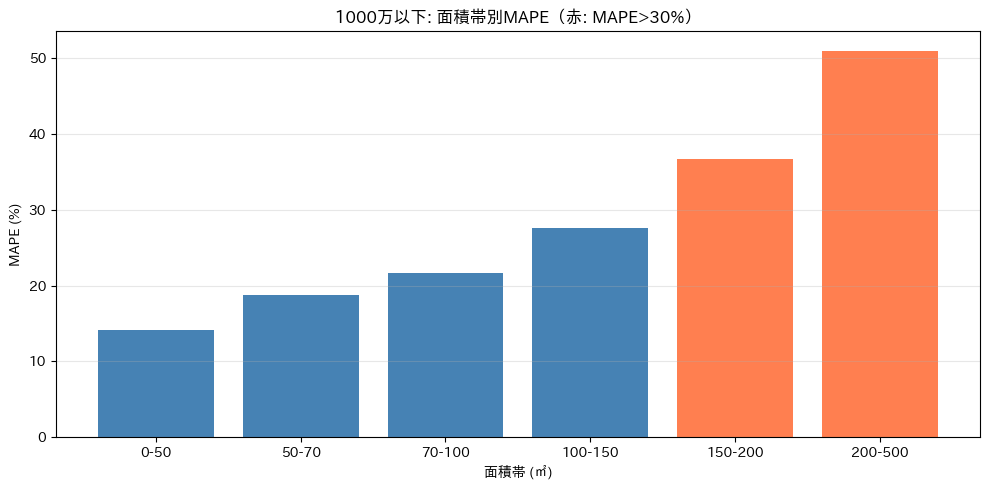

In [11]:
# 面積別MAPEの可視化
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(area_df))
colors = ["coral" if m > 30 else "steelblue" for m in area_df["MAPE"].to_list()]
bars = ax.bar(x, area_df["MAPE"].to_numpy(), color=colors)

ax.set_xlabel("面積帯 (㎡)")
ax.set_ylabel("MAPE (%)")
ax.set_title("1000万以下: 面積帯別MAPE（赤: MAPE>30%）")
ax.set_xticks(x)
ax.set_xticklabels(area_df["面積帯"].to_list())
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "mape_by_area_low_price.png", dpi=150, bbox_inches="tight")
plt.show()

In [12]:
# 単価分析
large_area = low_price.filter(pl.col("house_area") >= 100)
normal_area = low_price.filter(pl.col("house_area") < 100)

print("【単価(万円/㎡)分析】")
for df, name in [(large_area, "広い(>=100㎡)"), (normal_area, "通常(<100㎡)")]:
    unit_price = df["y"] / df["house_area"] / 10000
    print(f"  {name}: 平均 {unit_price.mean():.1f}万円/㎡, 中央値 {unit_price.median():.1f}万円/㎡")

print()
print("★ 広い物件は単価が約半分以下 → モデルが単価の違いを捉えられていない")

【単価(万円/㎡)分析】
  広い(>=100㎡): 平均 6.5万円/㎡, 中央値 6.6万円/㎡
  通常(<100㎡): 平均 15.3万円/㎡, 中央値 12.0万円/㎡

★ 広い物件は単価が約半分以下 → モデルが単価の違いを捉えられていない


## 7. 結論と改善案

### 問題の本質
- モデルは「面積が大きい→高価格」と学習している
- しかし1000万以下の広面積物件は単価が非常に低い（地方築古、リゾートマンション等）
- この「低単価×広面積」パターンをモデルが捉えられていない

### 改善案（exp010で実装予定）

#### 1. 単価関連の特徴量追加
-  = 周辺地価公示価格 / 面積
-  = 地価公示単価ベースの期待単価

#### 2. 交互作用フラグ
-  = 面積>=100㎡ & 築年数>=35年
-  = 地価公示単価が低いエリアフラグ

#### 3. 価格帯別対策
- サンプル重み付け（低価格帯の重みを上げる）
- 対数変換の調整

In [13]:
# サマリー表示
print("=" * 70)
print("exp009 低価格帯エラー分析サマリー")
print("=" * 70)
print()
print("【1000万以下の問題】")
print(f"  件数: {len(low_price):,}件 ({len(low_price)/len(train)*100:.1f}%)")
print(f"  MAPE: {low_price['ape'].mean():.1f}% (全体: {train['ape'].mean():.1f}%)")
print(f"  大エラー(APE>50%): {len(large_error):,}件 ({len(large_error)/len(low_price)*100:.1f}%)")
print()
print("【核心的発見】")
print("  1. 大エラーの100%が過大予測")
print(f"  2. 広面積(>=100㎡)物件のMAPE: {large_area['ape'].mean():.1f}%")
print(f"  3. 通常面積(<100㎡)物件のMAPE: {normal_area['ape'].mean():.1f}%")
print("  4. 広い物件の単価: 6.5万円/㎡ (通常: 15.3万円/㎡)")
print()
print("【改善案】")
print("  1. 単価関連特徴量の追加")
print("  2. 広面積×築古の交互作用フラグ")
print("  3. 低価格帯のサンプル重み付け")
print("=" * 70)

exp009 低価格帯エラー分析サマリー

【1000万以下の問題】
  件数: 48,356件 (13.3%)
  MAPE: 20.8% (全体: 12.5%)
  大エラー(APE>50%): 4,952件 (10.2%)

【核心的発見】
  1. 大エラーの100%が過大予測
  2. 広面積(>=100㎡)物件のMAPE: 29.8%
  3. 通常面積(<100㎡)物件のMAPE: 18.9%
  4. 広い物件の単価: 6.5万円/㎡ (通常: 15.3万円/㎡)

【改善案】
  1. 単価関連特徴量の追加
  2. 広面積×築古の交互作用フラグ
  3. 低価格帯のサンプル重み付け
